# Rastrigin optimisation example

In this notebook we illustrate the scalability of tempered SMC for Rastrigin function optimisation. This will allow us to verify empirically the derived asymptotics of the method.

## Imports

In [1]:
from collections import OrderedDict
from functools import partial

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability.substrates.jax.mcmc as mcmc
from jax.random import normal
from mpl_toolkits.mplot3d import axes3d

from tempered_smc_optimization.smc_minimizer import infinitely_tempered_smc

In [2]:
def potential(x, k, A=10):
    d = x.shape[1]
    res = -A * d + jnp.sum(x ** 2 - A * jnp.cos(2 * jnp.pi * x), 1)
    return res

def m0(n, key, d):
    return (10. * normal(key, (n, d)),)

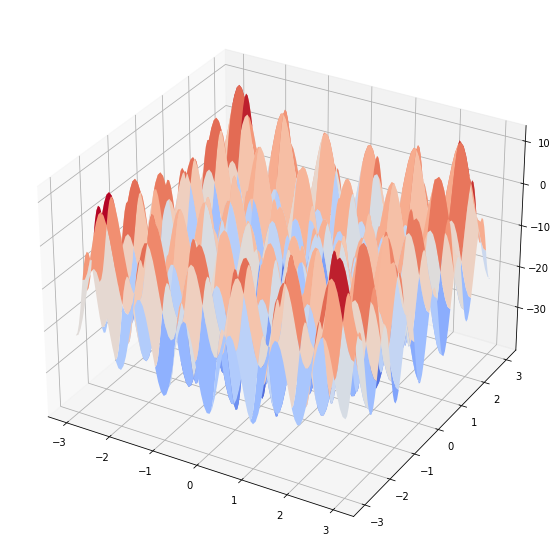

In [3]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Grab some test data.
x = y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], -1)
Z = jnp.vectorize(potential, signature=("(n,d)->(n)"), excluded=(1,))(XY, None)
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, cmap="coolwarm")

fig.savefig("./figures/rastrigin.png")

In [4]:
def mh_kernel(log_prob_fn):
    return mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        step_size=1e-3, num_leapfrog_steps=100)


In [5]:
means = OrderedDict()
stds = OrderedDict()
lambdas = OrderedDict()


In [6]:
ds = [1, 5, 10, 20]
ns = np.empty_like(ds)

In [52]:
infinitely_tempered_smc_d = lambda d: infinitely_tempered_smc(potential, 1000, 0.75, partial(m0, d=d), num_results=50,
                                                              max_lambda=1e3, max_n=400, make_kernel=mh_kernel)

In [53]:
for i, d in enumerate(ds):
    particles_history_d, lambdas_d, n = infinitely_tempered_smc_d(d)
    particles_history_d = particles_history_d[0]
    n = np.array(n)
    lambdas_d = np.array(lambdas_d)
    particles_history_d = np.array(particles_history_d)

    lambdas_d = lambdas_d[:n + 1]
    particles_history_d = particles_history_d[:n + 1]

    mean_d = particles_history_d.mean(axis=1)
    std_d = particles_history_d.std(axis=1)

    means[d] = mean_d
    stds[d] = std_d
    lambdas[d] = lambdas_d



Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

In [54]:
potential(jnp.zeros((50, 10)), None)

DeviceArray([-400., -400., -400., -400., -400., -400., -400., -400.,
             -400., -400., -400., -400., -400., -400., -400., -400.,
             -400., -400., -400., -400., -400., -400., -400., -400.,
             -400., -400., -400., -400., -400., -400., -400., -400.,
             -400., -400., -400., -400., -400., -400., -400., -400.,
             -400., -400., -400., -400., -400., -400., -400., -400.,
             -400., -400.], dtype=float32)

In [55]:
potential(means[20], None)

DeviceArray([-267.44724  , -270.37686  , -160.67632  , -181.457    ,
             -123.2388   , -151.61003  ,  -82.96787  ,  -20.413452 ,
              -54.782578 ,  -51.22821  ,   15.248474 ,    5.4622345,
              -32.286438 ,  -75.57387  , -129.0601   , -120.287994 ,
             -122.57565  , -164.70306  , -133.84102  , -128.99968  ,
             -167.56464  , -153.15343  , -167.88503  , -163.44492  ,
             -173.59319  , -207.96893  , -217.3684   , -195.50113  ,
             -159.99829  , -136.60469  , -132.39835  , -129.82196  ,
             -144.0155   , -151.70932  , -156.46915  , -156.05719  ,
             -160.13513  , -162.62927  , -169.07764  , -167.78583  ,
             -173.70634  , -181.8759   , -196.00414  , -213.88199  ,
             -225.82973  , -219.12985  , -214.86938  , -268.4507   ,
             -337.50946  , -369.37317  , -374.56635  , -375.10428  ,
             -375.12534  , -375.12463  , -375.12512  , -375.12534  ,
             -375.12552  , -375.12

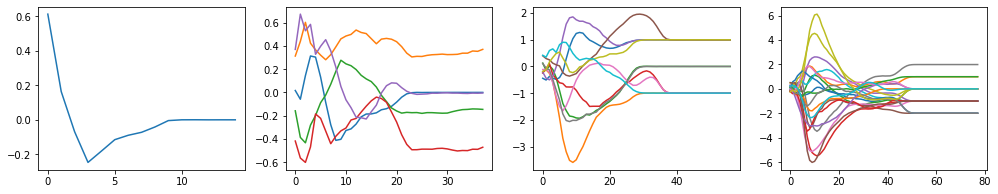

In [56]:
fig, axes = plt.subplots(ncols=len(ds), figsize=(17, 3))
for d, ax in zip(ds, axes):
    ax.plot(means[d], label="Mean")

fig.savefig("./figures/rastrigin_convergence.png")


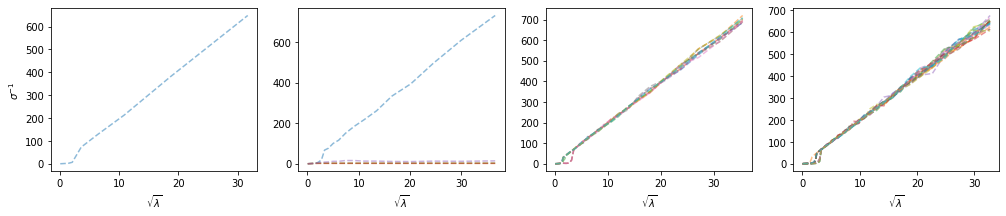

In [57]:
fig, axes = plt.subplots(ncols=len(ds), figsize=(17, 3))
for i, (d, ax) in enumerate(zip(ds, axes)):
    ax.plot(np.sqrt(lambdas[d][1:]), 1/stds[d][1:], label="Std", linestyle="--", alpha=0.5)
    ax.set_xlabel(r"$\sqrt{\lambda}$")
    if i == 0:
        ax.set_ylabel(r"$\sigma^{-1}$")
#     ax.semilogy(1. / np.sqrt(lambdas[d][1:]), label="Lambdas", alpha=0.33)

fig.savefig("./figures/rastrigin_std_lambda.png")

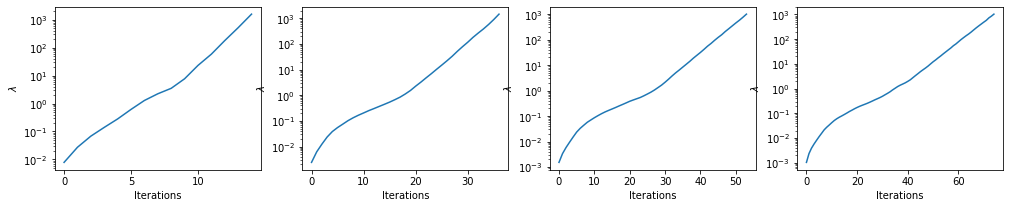

In [11]:
fig, axes = plt.subplots(ncols=len(ds), figsize=(17, 3))
for i, (d, ax) in enumerate(zip(ds, axes)):
    ax.semilogy(lambdas[d][1:], linestyle="-")
    ax.set_ylabel(r"$\lambda$")
    ax.set_xlabel(r"Iterations")

#     ax.semilogy(1. / np.sqrt(lambdas[d][1:]), label="Lambdas", alpha=0.33)

fig.savefig("./figures/rastrigin_lambdas.png")

In [12]:
infinitely_tempered_smc_n = lambda n: infinitely_tempered_smc(potential, n, 0.75, partial(m0, d=5), num_results=50,
                                                              max_lambda=1e3, max_n=400, make_kernel=mh_kernel)

In [13]:
means_n = OrderedDict()
stds_n = OrderedDict()
lambdas_n = OrderedDict()

ns = [50, 100, 1000, 10000]
for i, N in enumerate(ns):
    particles_history_n, lambdas, n = infinitely_tempered_smc_n(N)
    particles_history_n = particles_history_n[0]
    n = np.array(n)
    lambdas = np.array(lambdas)
    particles_history_n = np.array(particles_history_n)

    lambdas = lambdas[:n + 1]
    particles_history_n = particles_history_n[:n + 1]

    mean_n = particles_history_n.mean(axis=1)
    std_n = particles_history_n.std(axis=1)

    means_n[N] = mean_n
    stds_n[N] = std_n
    lambdas_n[N] = lambdas



Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/400 [00:00<?, ?it/s]

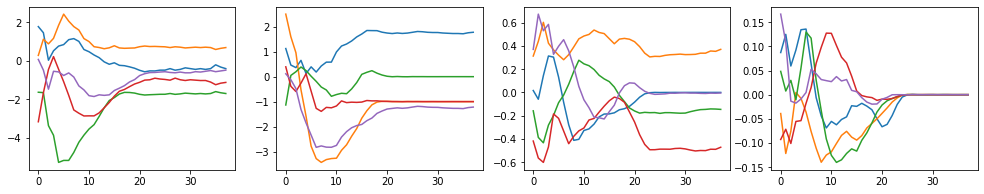

In [14]:
fig, axes = plt.subplots(ncols=len(ns), figsize=(17, 3))
for N, ax in zip(ns, axes):
    ax.plot(means_n[N], label="Mean")

fig.savefig("./figures/rastrigin_convergence_n.png")


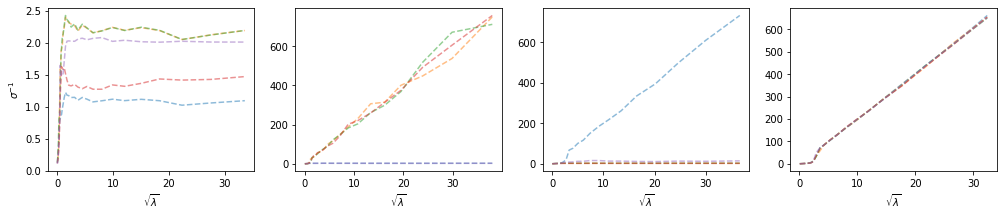

In [15]:
fig, axes = plt.subplots(ncols=len(ns), figsize=(17, 3))
for i, (N, ax) in enumerate(zip(ns, axes)):
    ax.plot(np.sqrt(lambdas_n[N][1:]), 1/stds_n[N][1:], label="Std", linestyle="--", alpha=0.5)
    ax.set_xlabel(r"$\sqrt{\lambda}$")
    if i == 0:
        ax.set_ylabel(r"$\sigma^{-1}$")
#     ax.semilogy(1. / np.sqrt(lambdas[d][1:]), label="Lambdas", alpha=0.33)

fig.savefig("./figures/rastrigin_std_lambda_n.png")